In [14]:
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
is_windowed = True #@param{type: "boolean"}
window_size = 10 #@param
is_normalization = True #@param{type: "boolean"}
def normalize(raw_data):
  mean = np.mean(raw_data, axis=0)
  std = np.std(raw_data, axis=0)
  normalized_data = (raw_data - mean) / (std + 1e-6)
  return normalized_data

# Function to create windowed data
def create_windowed_data(X, y, window_size=10):
    num_samples = X.shape[0] - window_size + 1  # Number of windows we can create
    windowed_X = np.array([(normalize(X[i:i + window_size]) if is_normalization else X[i:i + window_size]) for i in range(num_samples)])
    windowed_y = np.array([np.mean(y[i + window_size - 1]) for i in range(num_samples)])  # target at the end of the window
    # should delete
    # unnormalize_windowed_X = np.array([( X[i:i + window_size]) for i in range(num_samples)])
    # print(windowed_X[2000])
    # print(unnormalize_windowed_X[2000])
    return windowed_X, windowed_y

def load_and_preprocess_data(data_path):
    data = None
    labels = None
    users = []
    sessions = []
    # Walk through the folder structure
    for participant_folder in os.listdir(data_path):

      participant_path = os.path.join(data_path, participant_folder)
      if not os.path.isdir(participant_path):
        continue
      user = os.path.basename(participant_path)
      if ('p40' in user or 'p39' in user or 'p41' in user):
        continue
      for session_id in ['1', '2', '3']:
        file_pattern = os.path.join(participant_path, f'*-{session_id}.npy')
        real = np.array([])
        imag = np.array([])
        force = np.array([])
        for file in glob.glob(file_pattern):
          if 'real' in file:
            with open(file, 'rb') as f:
              real = np.load(f)
          elif 'imag' in file:
            with open(file, 'rb') as f:
              imag = np.load(f)
          elif 'force' in file:
            with open(file, 'rb') as f:
              force = np.load(f)
        num_entries = real.shape[0]
        new_data = np.concatenate([real, imag], axis=1)
        new_force = force
        if is_windowed:
          new_data, new_force = create_windowed_data(new_data, force, window_size=window_size)
        if data is not None:
          data = np.append(data, new_data, axis=0)
        else:
          data = new_data
        labels = np.append(labels, new_force, axis=0) if labels is not None else new_force
        users.extend([user] * new_data.shape[0])
        sessions.extend([session_id] * num_entries)
    return data, labels, np.array(users), np.array(sessions)

# Path to the extracted dataset
data_path = '/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data'

# Load and preprocess the data
data, labels, users, sessions = load_and_preprocess_data(data_path)

print(data.shape)
print(labels.shape)
# label_set = np.unique(labels)
print(np.unique(users))
print(np.unique(sessions))


(315274, 10, 12)
(315274,)
['p24' 'p25' 'p26' 'p27' 'p28' 'p29' 'p30' 'p31' 'p32' 'p33' 'p34' 'p35'
 'p36' 'p37' 'p38']
['1' '2' '3']


In [19]:
#@title Approach 1 - RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut

is_LOSO = True #@param{type: "boolean"}
num_estimators = 10 #@param
def pred(X_train, X_test, y_train, y_test):
  model = RandomForestRegressor(
      n_estimators=num_estimators,
      random_state=42)
  if len(X_train.shape) > 2:
    X_train = X_train.reshape(X_train.shape[0], window_size * 12)
    X_test = X_test.reshape(X_test.shape[0], window_size * 12)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  return (mse, r2)


if not is_LOSO:
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
  mse, r2 = pred(X_train, X_test, y_train, y_test)
  print(mse)
  print(r2)
else:
  logo = LeaveOneGroupOut()
  logo_session = LeaveOneGroupOut()
  LOSO_result = {}
  print(users)
  for train_index, test_index in logo.split(data, labels, groups=users):
    current_group = users[test_index[0]]
    print(users[test_index])
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    LOSO_result[current_group] = pred(X_train, X_test, y_train, y_test)
    print(LOSO_result[current_group])
    for fs_train_index, fs_test_index in logo_session.split(X_test, y_test, groups=sessions[test_index]):
      current_session = sessions[fs_test_index[0]]
      print(sessions[fs_test_index])
      fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index]
      fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index]
      LOSO_result[current_group] = pred(fs_X_test, X_test, fs_y_test, y_test)
      print(LOSO_result[current_group])
      break


  print(LOSO_result)


['p30' 'p30' 'p30' ... 'p35' 'p35' 'p35']
['p24' 'p24' 'p24' ... 'p24' 'p24' 'p24']
(9.413270236156059, -0.21123565495472052)
['1' '1' '1' ... '3' '3' '3']
(6.195065701768819, 0.20286103824491553)
['p25' 'p25' 'p25' ... 'p25' 'p25' 'p25']
(11.835988116386982, -0.08484882802127336)
['1' '1' '1' ... '1' '1' '1']
(6.292808752270733, 0.4232212695101262)
['p26' 'p26' 'p26' ... 'p26' 'p26' 'p26']
(7.5939921820876375, -0.355172499432834)
['1' '1' '1' ... '2' '2' '2']
(4.113032040691463, 0.26601611152845717)
['p27' 'p27' 'p27' ... 'p27' 'p27' 'p27']
(15.983847812670401, -0.08672778400940029)
['1' '1' '1' ... '2' '2' '2']
(8.65003166310415, 0.4118919392234982)
['p28' 'p28' 'p28' ... 'p28' 'p28' 'p28']
(14.606040890413873, -0.0553088092038625)
['1' '1' '1' ... '1' '1' '1']
(10.088758915184602, 0.271071727307301)
['p29' 'p29' 'p29' ... 'p29' 'p29' 'p29']
(13.073590553933421, 0.018120174086018626)
['1' '1' '1' ... '1' '1' '1']
(8.516902301211134, 0.3603459956665427)
['p30' 'p30' 'p30' ... 'p30' 'p

In [18]:
# LOSO_result = {'p24': (24.90697532838613, -2.1707521764685893), 'p25': (25.088540465810784, -1.3534596657668154), 'p26': (10.721591102270521, -0.9132737279275891), 'p27': (26.489628593655457, -0.8016027463905722), 'p28': (22.444215871204605, -0.6584552065639588), 'p29': (25.06006570312082, -0.9221363285487973), 'p30': (26.147049767423365, -0.880818944955466), 'p31': (42.90885222261295, -1.6780911775022016), 'p32': (59.18871376844276, -3.3029442037528387), 'p33': (18.589459724654944, -0.7277160071741955), 'p34': (15.91594533759355, -0.4680131948250663), 'p35': (21.059298312598553, -0.44994203569086144), 'p36': (12.978648195919392, -0.4947250065216089), 'p37': (5.060074266122278, -0.3490838856104239), 'p38': (9.640156720249117, -0.2979091084233212)}

print(LOSO_result)
print(LOSO_result.values())
print( np.mean([i for i, j in LOSO_result.values()]))
print( np.mean([j for i, j in LOSO_result.values()]))


NameError: name 'LOSO_result' is not defined

In [ ]:
#@title Approach 1 - RandomForestClassifier - 3 class

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


is_finegrained = False #@param{type: "boolean"}
is_LOSO = True #@param{type: "boolean"}

low_pressure_boundary = 4 #@param
high_pressure_boundary = 7 #@param
classifier = RandomForestClassifier(n_estimators=10, random_state=42)

target_names = [str(i) for i in range(10)] if is_finegrained else ['light', 'median', 'hard']

def classify_pressure(pressure):
  if is_finegrained:
    if pressure >= 9.5:
      return 9
    else:
      return int(np.round(pressure))
  else:
    if pressure == 0:
      return 0
    elif pressure < low_pressure_boundary:
      return 1
    elif pressure < high_pressure_boundary:
      return 2
    else:
      return 3

def pred(X_train, X_test, y_train, y_test):
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  # class_report = classification_report(y_test, y_pred, target_names=target_names)
  print(f"Accuracy: {accuracy * 100}")
  # print(f"Classification Report:\n{class_report}")
  # Plot confusion matrix as a heatmap
  # conf_matrix = confusion_matrix(y_test, y_pred)
  # plt.figure(figsize=(10, 7))
  # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
  # plt.xlabel('Predicted')
  # plt.ylabel('Actual')
  # plt.title('Confusion Matrix')
  # plt.show()
  return accuracy

labels_c = np.array([classify_pressure(y_i) for y_i in labels])
if not is_LOSO:
  X_train, X_test, y_train, y_test = train_test_split(data, labels_c, test_size=0.2, random_state=42)
  accuracy = pred(X_train, X_test, y_train, y_test)
  print(accuracy)
else:
  logo = LeaveOneGroupOut()
  logo_session = LeaveOneGroupOut()
  LOSO_result = {}
  for train_index, test_index in logo.split(data, labels_c, groups=users):
    current_group = users[test_index[0]]
    print(users[test_index])
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels_c[train_index], labels_c[test_index]
    LOSO_result[current_group] = pred(X_train, X_test, y_train, y_test)

    for fs_train_index, fs_test_index in logo_session.split(X_test, y_test, groups=sessions[test_index]):
      current_session = sessions[fs_test_index[0]]
      print(sessions[fs_test_index])
      fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index]
      fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index]
      LOSO_result[current_group] = pred(fs_X_test, X_test, fs_y_test, y_test)
      break

  print(LOSO_result)
print(np.mean(list(LOSO_result.values())))


['p24' 'p24' 'p24' ... 'p24' 'p24' 'p24']
Accuracy: 31.58879273130923
['1' '1' '1' ... '1' '1' '1']
Accuracy: 57.24710670750509
['p25' 'p25' 'p25' ... 'p25' 'p25' 'p25']
Accuracy: 43.89288047028086
['1' '1' '1' ... '1' '1' '1']
Accuracy: 51.324997667257634
['p26' 'p26' 'p26' ... 'p26' 'p26' 'p26']
Accuracy: 40.183711753671005
['1' '1' '1' ... '1' '1' '1']
Accuracy: 57.88213985380685
['p27' 'p27' 'p27' ... 'p27' 'p27' 'p27']
Accuracy: 12.127236580516898
['1' '1' '1' ... '1' '1' '1']
Accuracy: 88.5296914167171
['p28' 'p28' 'p28' ... 'p28' 'p28' 'p28']
Accuracy: 53.80035721373289
['1' '1' '1' ... '1' '1' '1']
Accuracy: 66.31772177019249
['p29' 'p29' 'p29' ... 'p29' 'p29' 'p29']
Accuracy: 53.39649911674964
['1' '1' '1' ... '1' '1' '1']
Accuracy: 88.43209678282747
['p30' 'p30' 'p30' ... 'p30' 'p30' 'p30']
Accuracy: 43.58525821969547
['1' '1' '1' ... '1' '1' '1']
Accuracy: 52.93603148729774
['p31' 'p31' 'p31' ... 'p31' 'p31' 'p31']
Accuracy: 28.381534039877852
['1' '1' '1' ... '1' '1' '1']
A

In [70]:
print(LOSO_result.values())
print(np.mean(list(LOSO_result.values())))

dict_values([(3.353999376296997, 0.5076717138290405), (1.2844772338867188, 0.7334468960762024), (2.530693531036377, 0.6102748513221741), (1.1492737531661987, 0.7537103295326233), (2.2010581493377686, 0.6589004993438721), (1.7393109798431396, 0.6807383298873901), (2.7376911640167236, 0.6069437265396118), (1.4029844999313354, 0.6809940338134766), (1.4247864484786987, 0.7117848992347717), (2.3078644275665283, 0.6181976199150085), (1.4506057500839233, 0.7286573648452759), (1.832534909248352, 0.6841179728507996), (1.3098976612091064, 0.743127703666687), (1.4241036176681519, 0.76372230052948), (1.1943401098251343, 0.6863076686859131)])
1.2504072507222495


In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test_classification, y_pred)
conf_matrix = confusion_matrix(y_test_classification, y_pred)
class_report = classification_report(y_test_classification, y_pred, target_names=target_names)

# Print accuracy and classification report
print(f"Accuracy: {accuracy * 100}")
print(f"Classification Report:\n{class_report}")

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=["light", "median", "hard"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#@title Modeling

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint


model = Sequential()
# model.add(Reshape((12, 1)))
# model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(12,)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Define the path to save the best model
checkpoint_filepath = '/tmp/best_model.h5'

# Create a ModelCheckpoint callback to save the model with the lowest validation loss
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',  # You can also use 'val_accuracy' to monitor accuracy instead
    verbose=1,
    save_best_only=True,
    mode='min'  # 'min' for minimizing loss, 'max' for maximizing accuracy
)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

Epoch 1/20
8164/8176 [============================>.] - ETA: 0s - loss: 14.7458 - accuracy: 3.4067e-04
Epoch 1: val_loss improved from inf to 14.71763, saving model to /tmp/best_model.h5
8176/8176 [==============================] - 17s 2ms/step - loss: 14.7469 - accuracy: 3.4019e-04 - val_loss: 14.7176 - val_accuracy: 3.6694e-04
Epoch 2/20
8154/8176 [============================>.] - ETA: 0s - loss: 14.7416 - accuracy: 3.4109e-04
Epoch 2: val_loss did not improve from 14.71763
8176/8176 [==============================] - 17s 2ms/step - loss: 14.7448 - accuracy: 3.4019e-04 - val_loss: 14.7176 - val_accuracy: 3.6694e-04
Epoch 3/20
8169/8176 [============================>.] - ETA: 0s - loss: 14.7449 - accuracy: 3.4046e-04
Epoch 3: val_loss did not improve from 14.71763
8176/8176 [==============================] - 17s 2ms/step - loss: 14.7448 - accuracy: 3.4019e-04 - val_loss: 14.7176 - val_accuracy: 3.6694e-04
Epoch 4/20
1791/8176 [=====>........................] - ETA: 11s - loss: 14.837

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3741417284830.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
best_model = tf.keras.models.load_model('/tmp/best_model.h5')

223/223 [==============================] - 0s 1ms/step


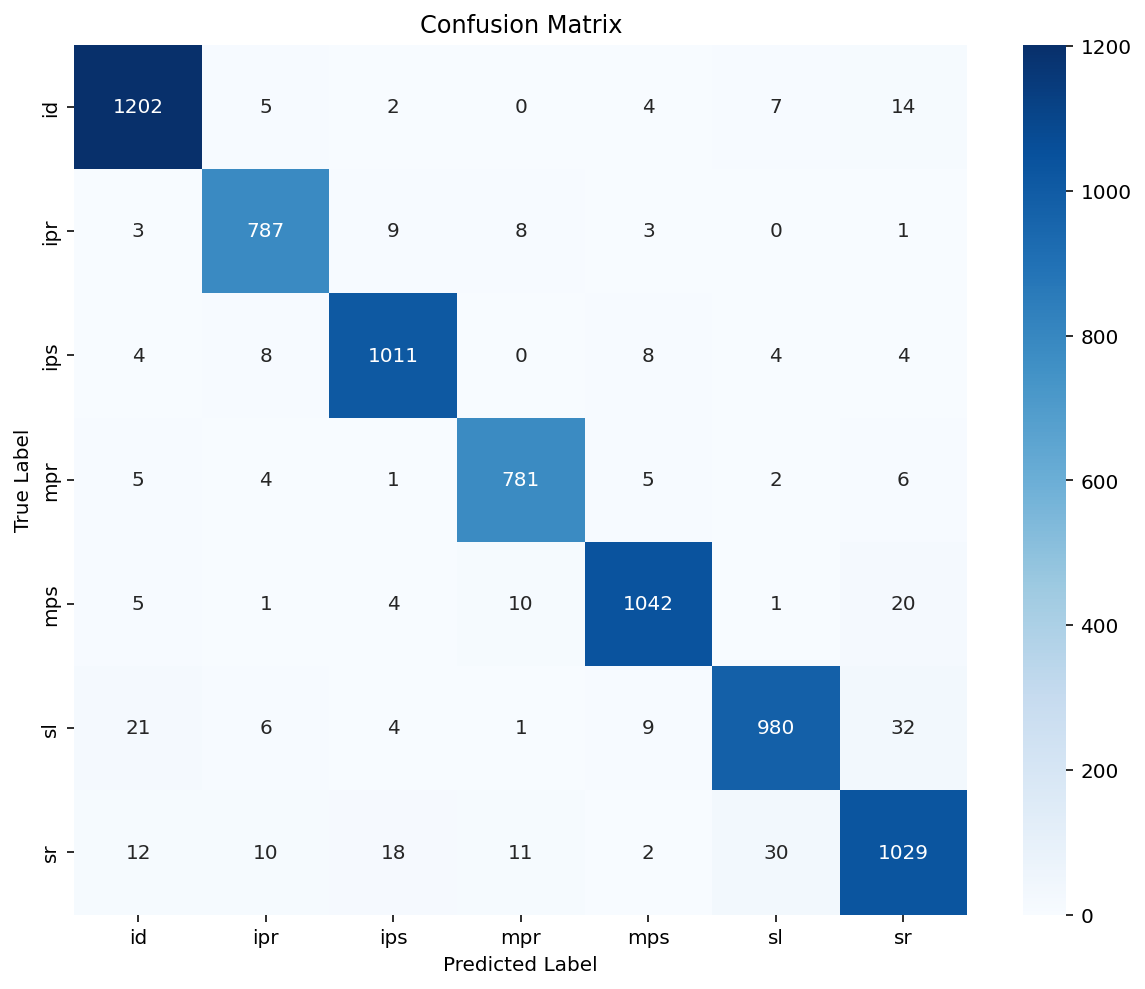

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sample training and evaluation dataset setup
# This assumes you have your X_train, X_test, y_train, and y_test data ready

# Convert y_test from one-hot encoding to single class labels (for confusion matrix)
y_test_labels = np.argmax(y_test, axis=1)

# Make predictions using the trained model
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

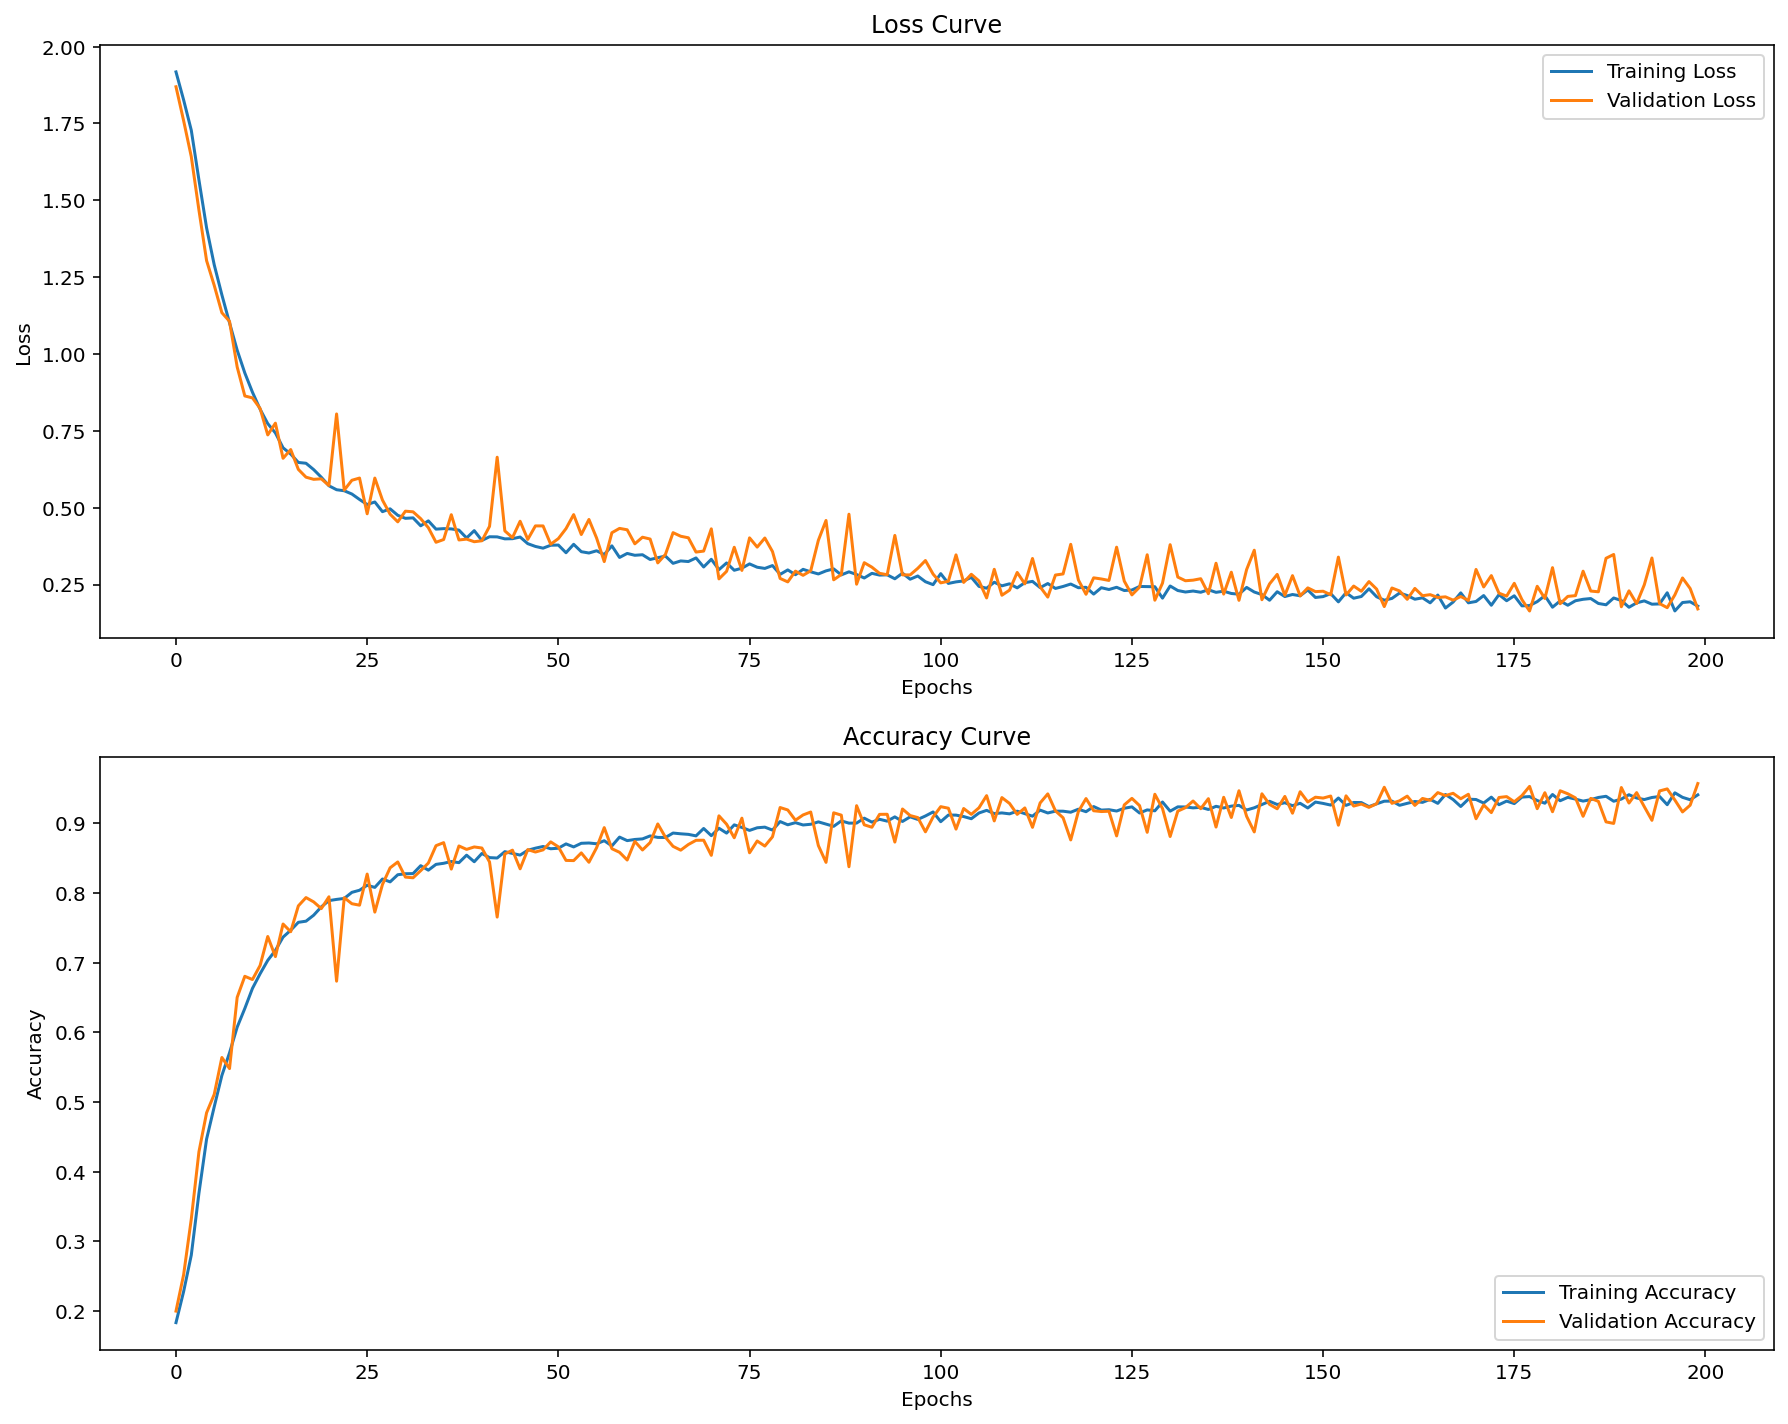

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable that stores the training history from model.fit()

# Create subplots for loss and accuracy curves
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

# Plot the training and validation loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

# Plot the training and validation accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')

# Display the plots
plt.show()

In [ ]:
# with gfile.Open('/x20/users/ca/cadyxu/eit/microgesture/best_model.h5', 'wb') as f:
#   best_model.save(f)
gfile.Copy('/tmp/best_model.h5', '/x20/users/ca/cadyxu/eit/microgesture/best_model.h5', overwrite=True)

In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Assume data, labels, and users (user IDs) are available from earlier preprocessing
# data: The input data (X)
# labels: The target labels (y)
# users: User or participant IDs corresponding to each data point

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(indexed_labels, num_classes=len(label_set))

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()

# Prepare to store accuracy from each fold
fold_accuracies = []

LOSO_result = {}

# Loop over each fold in LOSO
for train_index, test_index in logo.split(normalized_data, labels_one_hot, groups=sessions):
    # Split data into training and testing sets for the current fold
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels_one_hot[train_index], labels_one_hot[test_index]

    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(60,
    12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(label_set), activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



    # Define the path to save the best model
    checkpoint_filepath = f'/tmp/{users[test_index][0]}_best_model.h5'

    # Create a ModelCheckpoint callback to save the model with the lowest validation loss
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
        verbose=1,
        save_best_only=True,
        mode='max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
    )

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

    # Evaluate the model
    cur_best_model = tf.keras.models.load_model(checkpoint_filepath)
    test_loss, test_acc = cur_best_model.evaluate(X_test, y_test)
    gfile.Copy(checkpoint_filepath, f'/x20/users/ca/cadyxu/eit/microgesture/{users[test_index][0]}_best_model.h5', overwrite=True)

    # Save the test accuracy for this fold
    fold_accuracies.append(test_acc)
    print(f"LOSO user: {users[test_index]}")
    print(f"Fold Accuracy: {test_acc} loss: {test_loss}")
    LOSO_result[users[test_index][0]] = (test_acc, test_loss)

# Calculate the average accuracy across all folds
avg_accuracy = np.mean(fold_accuracies)
print(f"Average LOSO Accuracy: {avg_accuracy}")

Epoch 1/30
735/735 [==============================] - ETA: 0s - loss: 1.7697 - accuracy: 0.3004
Epoch 1: val_accuracy improved from -inf to 0.26259, saving model to /tmp/p01_best_model.h5
735/735 [==============================] - 6s 4ms/step - loss: 1.7697 - accuracy: 0.3004 - val_loss: 3.6996 - val_accuracy: 0.2626
Epoch 2/30
719/735 [============================>.] - ETA: 0s - loss: 1.3270 - accuracy: 0.4822
Epoch 2: val_accuracy improved from 0.26259 to 0.27391, saving model to /tmp/p01_best_model.h5
735/735 [==============================] - 3s 4ms/step - loss: 1.3245 - accuracy: 0.4837 - val_loss: 3.1971 - val_accuracy: 0.2739
Epoch 3/30
727/735 [============================>.] - ETA: 0s - loss: 1.0405 - accuracy: 0.5942
Epoch 3: val_accuracy improved from 0.27391 to 0.27957, saving model to /tmp/p01_best_model.h5
735/735 [==============================] - 3s 4ms/step - loss: 1.0395 - accuracy: 0.5944 - val_loss: 4.5717 - val_accuracy: 0.2796
Epoch 4/30
725/735 [=================

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3741417284830.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
